# Bayesian Parameter Estimation

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

In this notebook we will develop the Bayesian parameter estimation of the missing MWC parameters using Markov-Chain Monte Carlo sampling. Recall that the fold-change in gene expression for the simple repression architecture is given by
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1},
\tag{1}
$$
where $\beta \equiv \frac{1}{k_BT}, $ $c$ is the inducer concentration, $K_A$ and $K_I$ are the dissociation constants of the inducer binding to the repressor in the active and inactive state, respectively, $\Delta\varepsilon_{AI}$ is the energy difference between the active and inactive state conformations, $R$ is the repressor copy number, $N_{NS}$ is the number of non-specific binding sites where the repressor can bind, and $\Delta\varepsilon_{RA}$ is the binding energy of the repressor to the DNA.

The objective of the parameter estimation is to compute the probability distribution of the parameters $K_A$, $K_I$, given the data $D$. By Bayes theorem this is written as
$$
P(K_A, K_I \mid D, I) = \frac{P(D \mid K_A, K_I, I)P(K_A, K_I \mid I)}{P(D \mid I)},
\tag{2}
$$
where $I$ represents all the previous information we have.

We know that the dissociation constants are scaling parameters, which implies they have a uniform distribution in log scale. In other words, having a dissociation constant of 10 M or 0.1 M has "the same magnitude", but in opposite directions. That is why we define $\tilde{k}_A \equiv -\log\frac{K_A}{c_o}$, and $\tilde{k}_I \equiv -\log\frac{K_I}{c_o}$, where $c_o$ is a reference concentration to make the parameter dimensionless. This definition allow us to sample these parameters in log scale. With the reparametrization we write the fold-change as
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_A}} \right)^2}{\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_A}} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{c_o}\cdot e^{\tilde{k_I}} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1}.
\tag{3}
$$

We then simply rewrite Eq. 2 as
$$
P(\tilde{k}_A, \tilde{k}_I \mid D, I) = \frac{P(D \mid \tilde{k}_A, \tilde{k}_I, I)P(\tilde{k}_A, \tilde{k}_I \mid I)}{P(D \mid I)},
\tag{4}
$$
Now we proceed to choose the form of the terms in Eq. 4.

## Setting statistical model for parameter estimation.

The simplest statistical model for the distribution of errors in the measurements consists on the following assumptions:
1. each measurement is independent.
2. the errors around the theoretical curve are Gaussian distributed.
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

It is important to indicate that each element of $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$) and the independent variables (the repressor copy number $R$, the binding energy $\Delta\varepsilon_{RA} $ and the IPTG concentration $c$). With this in hand we implement the first assumption of having independent measurements writing the first term on the left-hand side of Eq. 4 as
\begin{equation}
P(D \mid \tilde{k}_A, \tilde{k}_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)}, I),
\tag{5}
\end{equation}
where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

By implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \tilde{k}_A, \tilde{k}_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\tilde{k}_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\tag{6}
\end{equation}

where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the prior probability $P(\tilde{k}_A, \tilde{k}_I, \sigma \mid I)$ we can assume that the 3 parameters $\tilde{k}_A, \tilde{k}_I$ and $\sigma$ are independent. Furthermore, we know that $\sigma$ is a scaling parameter so it should have a Jeffreys' prior. The transformation from $K_A$ and $K_I$ to $\tilde{k}_A$ and $\tilde{k}_I$ was done in the first place to uniformly sample the dissociation constants in log scale, implying that they must have uniform priors. This means that we have
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \sigma \mid I) \equiv \frac{1}{\tilde{k}_{A_\max} - \tilde{k}_{A_\min}}\cdot\frac{1}{\tilde{k}_{I_\max} - \tilde{k}_{I_\min}}\cdot\frac{1}{\sigma}.
\tag{7}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as
\begin{array}
 P \left( \tilde{k}_A, \tilde{k}_I, \sigma \mid D, I \right) \propto &\left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)} \right) \right)^2 \right] \\
&\cdot\frac{1}{\sigma} \cdot \frac{1}{\tilde{k}_{A_\max} - \tilde{k}_{A_\min}} \cdot \frac{1}{\tilde{k}_{I_\max} - \tilde{k}_{I_\min}},
\tag{8}
\end{array}
where we ignore the denominator in Eq. 4 as it serves as a normalization constant.

For reasons of numerical accuracy it is convenient to work with the log of the posterior probability distribution. By taking the log of Eq. 8 we find
$$
\ln P(\tilde{k}_A, \tilde{k}_I, \sigma \mid D, I) \propto (n + 1) \ln\sigma + \sum_{i=1}^n \frac{1}{2\sigma^2} \left( fc_{exp}^{(i)} - fc\left(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)} \right) \right)^2
\tag{9}
$$

Let us now define functions to compute the **log** probability distribution!

In [2]:
def log_likelihood(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the log likelihood probability.
    Parameters
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var, epsilon=4.5,
             ea_range=[6 -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, sigma = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var, epsilon)

## Running the MCMC on the data 
Now that we defined our functions, let's test it on the experimental data we have gathered so far.

In [3]:
datadir = '../../data/'
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160804  mrazomej       O2           -13.9    RBS1L         870      0.0   
3  20160804  mrazomej       O2           -13.9     RBS1         610      0.0   
4  20160804  mrazomej       O2           -13.9  RBS1027         130      0.0   
5  20160804  mrazomej       O2           -13.9   RBS446          62      0.0   
6  20160804  mrazomej       O2           -13.9  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3624.474605         111.851286       0.007146  
3  3619.786265         107.162946       0.006847  
4  3717.019527         204.396208       0.013059  
5  3854.650585         342.027265       0.021853  
6  4169.802851         657.179531       0.041988

The log posterior takes as arguments the parameters, and a series of independent and dependent variables. The independent variables are the IPTG concentration, the repressor copy number and the binding energy of the repressor to the operator.

Let's extract those features from the data for only one strain.

In [6]:
rbs = df[(df.rbs=='RBS1027') & (df.operator=='O2')]
# extracting independent and dependent variables
indep_var = rbs[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df[df.rbs=='RBS1027'].fold_change_A

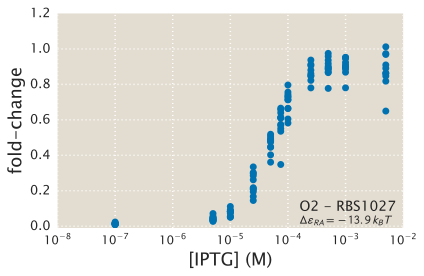

In [7]:
fig, ax = plt.subplots(1, 1)

ax.plot(rbs.IPTG_uM / 1E6,
         rbs.fold_change_A, 'o',
         alpha=0.7)
ax.set_xscale('log')
ax.set_xlabel('[IPTG] (M)')
ax.set_ylabel('fold-change')
ax.set_xlim([1E-8, 1E-2])
ax.set_ylim([-0.01, 1.2])
# Add operator and binding energy labels.
ax.text(0.7, 0.08, r'{0}'.format('O2 - RBS1027'), transform=ax.transAxes, 
        fontsize=14)
ax.text(0.7, 0.02,
        r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %-13.9,
        transform=ax.transAxes, fontsize=12)

plt.tight_layout()

Now let's define all the necessary stuff to run the MCMC.

To initialize the walkeres we use the non-linear regression approach to find the most probable parameter values and then initialize the walkers within that region using `numpy`'s `multivariate_normal` sampler.

In [8]:
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(rbs, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

In [9]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

Let's instanciate the sampler

In [10]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

Perform the burn-in steps.

In [11]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Once we do the burn-in steps let's now run the real MCMC routine!

For convenience we will pickle the sampler such that we can load the MCMC results without having to re-run the code.

In [12]:
sample = True
if sample:
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/O2_RBS1027.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

Let's visualize the results!

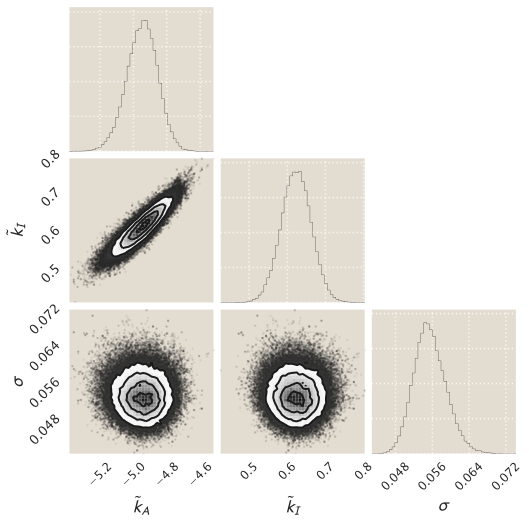

In [13]:
# Load the flat-chain
with open('../../data/mcmc/O2_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\tilde{k}_A$', r'$\tilde{k}_I$', r'$\sigma$'])

### Reporting the results.

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain.

In [14]:
# Load the flat-chain
with open('../../data/mcmc/O2_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma = gauss_flatchain[max_idx]
Ka, Ki = np.exp(-ea), np.exp(-ei)

# ea range
ea_hpd = mwc.hpd(gauss_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.2f} -{2:0.2f} µM
Ki = {3:.2f} +{4:0.3f} -{5:0.3f} µM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 139.96 +29.56 -22.09 µM
Ki = 0.54 +0.043 -0.040 µM



Let's see how these parameters predict the rest of the strains.

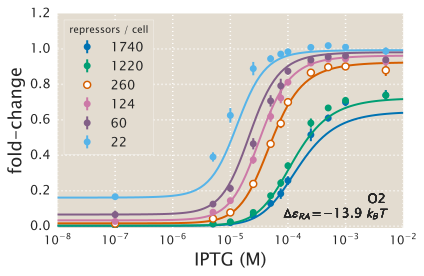

In [15]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 100)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O2']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize subplots
fig = plt.figure()
ax = plt.subplot(111)

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
         # plot the theory using the parameters from the fit.
        ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        if rbs=='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                     color=colors[j],
                    label=None,  linestyle='none')
            ax.plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, marker='o', markeredgewidth=1.5, 
                    markeredgecolor=colors[j],
                    markerfacecolor='w', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                    linestyle='none')
        elif rbs!='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], linestyle='none')
                    # Label the plot with the operator name and the energy
        ax.text(0.95, 0.1, op + 
                '\n' + r'$\Delta\varepsilon_{RA} =$' +\
                '{:.1f}'.format(energies[op]) + r' $k_BT$',
                ha='right', va='center',
                transform=ax.transAxes, fontsize=13)

# Format the axis
ax.set_xscale('log')
ax.set_xlabel('IPTG (M)')
ax.set_ylabel('fold-change')
ax.set_ylim([-0.01, 1.2])
ax.set_xlim([1E-8, 1E-2])
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Make the labels be numeric
labels = [int(x) for x in labels]
# Sort both lists by this numeric label
labels, handles = (list(x) for x in zip(*sorted(zip(labels, handles), reverse=True)))
# Convert back the labels to strings
labels = [str(x) for x in labels]
# use this order for the legend
ax.legend(handles, labels, loc='upper left', title='repressors / cell')
plt.tight_layout()

# Plotting the credible region using the MCMC traces.

Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals.

Think about it in the following way: The MCMC walkers explore the parameter space in a way proportional to the probability of each of the parameters, so if we were to compute the fold change for each and every step this would be done proportionally to how probable each fold-change value is, taking into account all the possible complicated non-linear relationships between parameters.

It might be computationally more expensive, but this way guarantees that the credible regions are drawn according to the proper posterior probability of the parameters.

Let's define a function that takes the `emcee` `flatchains` and computes the confidence interval.

In [16]:
def mcmc_cred_region(IPTG, flatchain, R, epsilon_r,
                     mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameters.
        flatchain[:,0] = ~ka flat-chain
        flatchain[:,1] = ~ki flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

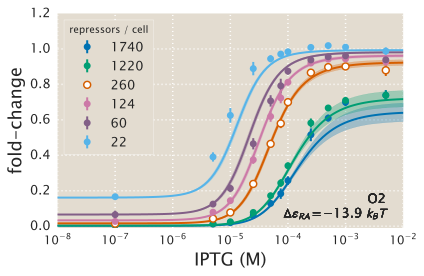

In [17]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 100)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O2']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize subplots
fig = plt.figure()
ax = plt.subplot(111)

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
         # plot the theory using the parameters from the fit.
        ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mcmc_cred_region(IPTG * 1E6, 
            gauss_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        if rbs=='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                     color=colors[j],
                    label=None,  linestyle='none')
            ax.plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, marker='o', markeredgewidth=1.5, 
                    markeredgecolor=colors[j],
                    markerfacecolor='w', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                    linestyle='none')
        elif rbs!='RBS1027':
            # plot the experimental data
            ax.errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], linestyle='none')
                    # Label the plot with the operator name and the energy
        ax.text(0.95, 0.1, op + 
                '\n' + r'$\Delta\varepsilon_{RA} =$' +\
                '{:.1f}'.format(energies[op]) + r' $k_BT$',
                ha='right', va='center',
                transform=ax.transAxes, fontsize=13)

# Format the axis
ax.set_xscale('log')
ax.set_xlabel('IPTG (M)')
ax.set_ylabel('fold-change')
ax.set_ylim([-0.01, 1.2])
ax.set_xlim([1E-8, 1E-2])
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Make the labels be numeric
labels = [int(x) for x in labels]
# Sort both lists by this numeric label
labels, handles = (list(x) for x in zip(*sorted(zip(labels, handles), reverse=True)))
# Convert back the labels to strings
labels = [str(x) for x in labels]
# use this order for the legend
ax.legend(handles, labels, loc='upper left', title='repressors / cell')
plt.tight_layout()

## Testing the prediction with other operators.

As a way to test how well the fit to a single strain can predict the rest of the operators, we will plot the predictions using this set of parameters for all of the data sets.

In [19]:
# Read the data
datadir = '../../data/'
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

Now we will plot using the predictions for the single fit strain.

O1
O2
O3


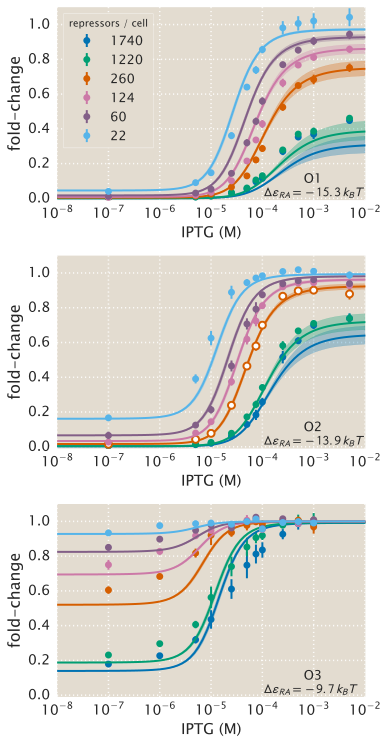

In [20]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3'] #, 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(3, 1, figsize=(5.5, 10.5))

# Loop through operators
for i, op in enumerate(operators):
    print(op)
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1e6,
            gauss_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax[i].fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        # Distinguish between the fit data and the predictions
        if (op == 'O2') & (rbs == 'RBS1027'):
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err, linestyle='none', color=colors[j])
            ax[i].plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                       fc_mean, marker='o', linestyle='none',
                       markeredgewidth=2, markeredgecolor=colors[j],
                       markerfacecolor='w', 
                       label=df[df.rbs=='RBS1027'].repressors.unique()[0] * 2)
        else:
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                    fmt='o', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j])

    # Add operator and binding energy labels.
    ax[i].text(0.8, 0.09, r'{0}'.format(op), transform=ax[i].transAxes, 
            fontsize=13)
    ax[i].text(0.67, 0.02,
            r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
            transform=ax[i].transAxes, fontsize=13)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].tick_params(labelsize=14)
    ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()

## Running the MCMC with all the data.

An interesting thing to try is to fit the dissociation constants using the data for all 3 operators O1, O2, and O3.

In [21]:
# extracting independent and dependent variables
indep_var = df[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df.fold_change_A

# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

In [22]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

In [23]:
sample = True
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/pool_data.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

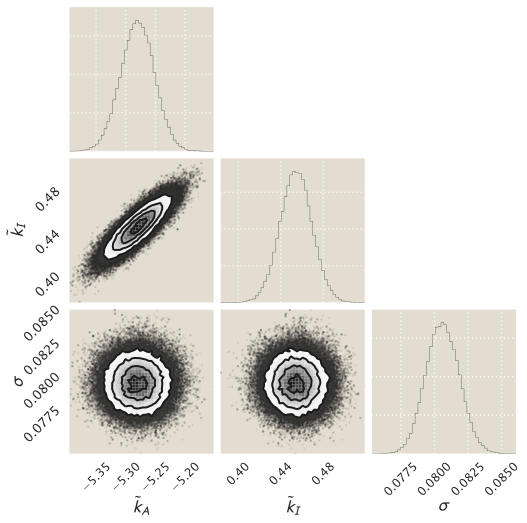

In [24]:
# read the flat-chain
with open('../../data/mcmc/pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    gauss_pool_flatlnprobability = unpickler.load()

# plot the corner plot
fig = corner.corner(gauss_pool_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\tilde{k}_A$', r'$\tilde{k}_I$', r'$\sigma$'])

In [27]:
# Load the flat-chain
with open('../../data/mcmc/pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma = gauss_flatchain[max_idx]
Ka, Ki = np.exp(-ea), np.exp(-ei)

# ea range
ea_hpd = mwc.hpd(gauss_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)
# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.3f} +{4:0.3f} -{5:0.3f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 196.36 +11.455 -10.516 uM
Ki = 0.635 +0.019 -0.019 uM



O1
O2
O3


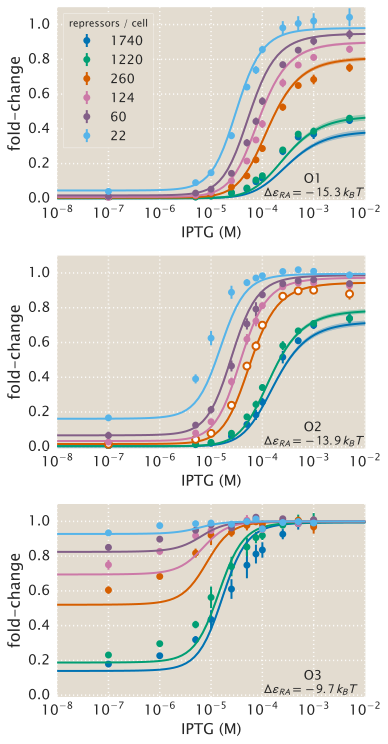

In [28]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3'] #, 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(3, 1, figsize=(5.5, 10.5))

# Loop through operators
for i, op in enumerate(operators):
    print(op)
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op]),
            color=colors[j], label=None)
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1e6,
            gauss_pool_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=energies[op])
        ax[i].fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                        alpha=0.3, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        # Distinguish between the fit data and the predictions
        if (op == 'O2') & (rbs == 'RBS1027'):
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err, linestyle='none', color=colors[j])
            ax[i].plot(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                       fc_mean, marker='o', linestyle='none',
                       markeredgewidth=2, markeredgecolor=colors[j],
                       markerfacecolor='w', 
                       label=df[df.rbs=='RBS1027'].repressors.unique()[0] * 2)
        else:
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                    fc_mean, yerr=fc_err,
                    fmt='o', label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j])

    # Add operator and binding energy labels.
    ax[i].text(0.8, 0.09, r'{0}'.format(op), transform=ax[i].transAxes, 
            fontsize=13)
    ax[i].text(0.67, 0.02,
            r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
            transform=ax[i].transAxes, fontsize=13)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].tick_params(labelsize=14)
    ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()